# Import packages

In [110]:
import torch
import torch.nn as nn
import torchdiffeq
from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import scipy.optimize as opt
import pickle
import numpy as np
import time

torch.set_default_dtype(torch.float)

# Define classes for parameter-container and sequence generator

In [111]:
"""
Class MassFricParams, manages data of a mass block sliding on rate-and-state friction surface, contains 
    Data:
        k : Spring stiffness
        m : Mass of the block
        V : Leading head speed of the spring
        g : Gravity
        RSParams : rate and state parameters, torch.tensor([a, b, DRS, f*])
        y0 : torch.tensor([initial x_1, initial v_1, initial state variable])
"""
class MassFricParams: 
    # Constructor
    def __init__(self, kmg, VT, RSParams, y0):
        # Define constant parameters k, m and g
        self.k = kmg[0]
        self.m = kmg[1]
        self.g = kmg[2]
        
        # Get the VT relation
        # print("VT: ", VT)
        self.V = VT[0, :]
        self.T = VT[1, :]
        
        # Get the displacement at T
        self.S = torch.zeros(self.V.shape)
        self.S[1:] = torch.cumulative_trapezoid(self.V, self.T)
        
        self.RSParams = RSParams
        self.y0 = y0
        
        # Get the function of V, S at T
        self.vtFunc = interp1d(self.T, self.V)
        self.stFunc = interp1d(self.T, self.S)
        
    # Define the function that gives V at t
    def VatT_interp(self, t):
        # Piecewise linear interplation
        if t < self.T[0]:
            v = self.V[0]
        elif t > self.T[-1]:
            v = self.V[-1]
        else:
            v = self.vtFunc(t)
        return torch.tensor(v, dtype=torch.float)
    
    # Define the function that gives S at t
    def SatT_interp(self, t):
        # Piecewise linear interplation
        if t < self.T[0]:
            s = self.S[0]
        elif t > self.T[-1]:
            s = self.S[-1]
        else:
            s = self.stFunc(t)
        return torch.tensor(s, dtype=torch.float)
    
    # Output the information of this class
    def print_info(self):
        print("-" * 20, " Mass and spring parameters ", "-"*20)
        print('k:        ', self.k)
        print('m:        ', self.m)
        print('g:        ', self.g)
        print('\n')
        
        print("-" * 20, " Rate-and-state parameters ", "-"*20)
        print('fr:       ', self.RSParams[3])
        print('a:        ', self.RSParams[0])
        print('b:        ', self.RSParams[1])
        print('DRS:      ', self.RSParams[2])
        print('y0:       ', self.y0)
        
        # Plot V at t
        plt.figure()
        plt.plot(self.T, self.V, linewidth = 2.0)
        plt.show()
        

In [112]:
"""
Class TimeSequenceGen, container for a Generated time sequence containing 
    Data:
        MFParams: Mass and friction parameters for the system
        T: Length of calculation
        
    Method:
        __init__ : Constructor
        calculateYAtT: Generate the sequence of [x_1, v_1, theta]
        
"""
class TimeSequenceGen:
    # Constructor
    def __init__(self, T, NofTPts, MFParams, rtol = 1.e-6, atol = 1.e-8, regularizedFlag = True):
        # Load the parameters
        self.T = T
        self.t = torch.linspace(0., T, NofTPts)
        self.MFParams = MFParams
        self.rtol = rtol
        self.atol = atol
        self.regularizedFlag = regularizedFlag
        
        # Generate the sequence
        st = time.time()
        self.default_y = self.calculateYAtT(self.t)
        self.time_cost = time.time() - st
        # print("Time cost to generate the sequence: ", self.time_cost)
        
    # Function DyDt, DyDt = f(t, y)
    def DyDt(self, t, y):
        
        # Need to use regularized rate-and-state
        a = self.MFParams.RSParams[0]
        b = self.MFParams.RSParams[1]
        DRS = self.MFParams.RSParams[2]
        fStar = self.MFParams.RSParams[3]
        
        # Regularized rate-and-state friction
#         tau = self.N * a * torch.asinh(
#                    self.Ds / 2. / Vr * torch.exp((fr + b * torch.log(Vr * self.theta / DRS)) / a)
#                    )
        # Get the displacement at t of the spring
        
        if self.regularizedFlag:
            DyDt = torch.tensor([y[1], 
                                 self.MFParams.k / self.MFParams.m * (self.MFParams.SatT_interp(t) - y[0]) - \
                                 self.MFParams.g * (a * torch.asinh(
                                     y[1] / 2.e-6 * torch.exp((fStar + b * torch.log(1.e-6 * y[2] / DRS)) / a)
                                 )), 
                                 1 - y[2] * y[1] / DRS])
        else:
            DyDt = torch.tensor([y[1], 
                                 self.MFParams.k / self.MFParams.m * (self.MFParams.SatT_interp(t) - y[0]) - \
                                 self.MFParams.g * (fStar + \
                                                    a * torch.log(y[1] / 1.e-6) + \
                                                    b * torch.log(1.e-6 * y[2] / DRS)), 
                                 1 - y[2] * y[1] / DRS])             
        # DEBUG LINES
#         print("-" * 30)
#         print('t = ', t)
#         print('y = ', y)
#         print('DyDt = ', DyDt)
        
        return DyDt
    
    
    # Generate the sequence of y(t) = [x_1(t), v_1(t), theta(t)]
    def calculateYAtT(self, t):
        y = odeint(self.DyDt, self.MFParams.y0, t, 
                   rtol = self.rtol, atol = self.atol, method = 'dopri5')
        return torch.transpose(y, 0, 1)
    
    # Visualize the sequence of y
    def plotY(self, t, y):
        # Plot Sequence of V(t) and N(t) given sample-index
        f, axs = plt.subplots(2, 2, figsize = (15, 15))

        # Plot x_1(t)
        axs[0][0].plot(1e6 * t, y[0, :], linewidth=2.0)
        axs[0][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[0][0].set_ylabel('Slip $x_1(t)\  \mathrm{[m]}$', fontsize=20)
        # axs[0][0].set_ylim([1e-15, 1e2])
        axs[0][0].grid()

        # Plot v_1(t)
        axs[0][1].semilogy(1e6 * t, y[1, :], linewidth=2.0)
        axs[0][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[0][1].set_ylabel('Slip rate $v_1(t)\ \mathrm{[m/s]}$', fontsize=20)
        # axs[0][1].set_ylim([0, 15])
        axs[0][1].grid()

        # Plot theta(t)
        axs[1][0].semilogy(1e6 * t, y[2, :], linewidth=3.0)
        axs[1][0].semilogy(1e6 * t, self.MFParams.RSParams[2] / y[1, :], linewidth=2.0)
        axs[1][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[1][0].set_ylabel('State Variable $\\theta(t)\ \mathrm{[s]}$', fontsize=20)
        axs[1][0].legend(['True', 'Steady state'], loc='best', fontsize=20)
        axs[1][0].grid()

#         # Plot \tau(t)
#         axs[1][1].plot(1e6 * t, tauAll[sample_idx, :], linewidth=2.0)
#         axs[1][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
#         axs[1][1].set_ylabel('Shear traction $\\tau(t)\ \mathrm{[MPa]}$', fontsize=20)
#         axs[1][1].grid()

#         f.suptitle("The " + str(sample_idx) + "th sequence", fontsize = 20)


# Adjoint derivatives

In [113]:
## O = \int_0^T (y[1](t) - v(t)) ^ 2 dt 
# To compute dO / d \beta, one needs to implement six functions
# In all tensors, the last dimension is time

# \partial o(y, yDot, t; \beta) / \partial y
def DoDy(y, v, t, MFParams):
    DoDy = torch.zeros(y.shape)
    DoDy[1, :] = 2. * (y[1, :] - v)
    return DoDy

# \partial o / \partial yDot
def DoDyDot(y, v, t, MFParams):
    return torch.zeros(y.shape)

# d/dt (\partial o / \partial yDot)
def DDoDyDotDt(y, v, t, MFParams):
    return torch.zeros(y.shape)

# \partial o / \partial \beta
def DoDBeta(y, v, t, MFParams):
    return torch.zeros([MFParams.RSParams.shape[0], y.shape[1]])

# \partial C / \partial y, unregularized
def DCDy(y, v, t, MFParams):
    DCDy = torch.zeros([y.shape[0], y.shape[0], y.shape[1]])
    DCDy[0, 1, :] = -1.
    DCDy[1, 0, :] = MFParams.k / MFParams.m
    DCDy[1, 1, :] = MFParams.g * MFParams.RSParams[0] / y[1, :]
    DCDy[1, 2, :] = MFParams.g * MFParams.RSParams[1] / y[2, :]
    DCDy[2, 1, :] = y[2, :] / MFParams.RSParams[2]
    DCDy[2, 2, :] = y[1, :] / MFParams.RSParams[2]
    return DCDy

# \partial C / \partial y, regularized
def DCDy_regularized(y, v, t, MFParams):
    # Compute auxiliary Q1 and !2
    Q1 = MFParams.RSParams[3] + MFParams.RSParams[1] * torch.log(1.e-6 * y[2, :] / MFParams.RSParams[2])
    Q2 = y[1, :] / 2 / 1.e-6 * torch.exp(Q1)
    
    # Calculate partial derivatives
    pfpy1 = MFParams.RSParams[0] * Q2 / torch.sqrt(1 + Q2^2) / y[1, :]
    pfpy2 = MFParams.RSParams[1] * Q2 / torch.sqrt(1 + Q2^2) / y[2, :]
    
    DCDy = torch.zeros([y.shape[0], y.shape[0], y.shape[1]])
    DCDy[0, 1, :] = -1.
    DCDy[1, 0, :] = MFParams.k / MFParams.m
    DCDy[1, 1, :] = MFParams.g * pfpy1
    DCDy[1, 2, :] = MFParams.g * pfpy2
    DCDy[2, 1, :] = y[2, :] / MFParams.RSParams[2]
    DCDy[2, 2, :] = y[1, :] / MFParams.RSParams[2]
    return DCDy

# \partial C / \partial yDot, unregularized
def DCDyDot(y, v, t, MFParams):
    DCDyDot = torch.zeros([y.shape[0], y.shape[0], y.shape[1]])
    DCDyDot[0, 0, :] = 1.
    DCDyDot[1, 1, :] = 1.
    DCDyDot[2, 2, :] = 1.
    return DCDyDot

# d/dt (\partial C / \partial yDot)
def DDCDyDotDt(y, v, t, MFParams):
    DDCDyDotDt = torch.zeros([y.shape[0], y.shape[0], y.shape[1]])
    return DDCDyDotDt

# \partial C / \partial \beta, unregularized
def DCDBeta(y, v, t, MFParams):
    DCDBeta = torch.zeros([y.shape[0], MFParams.RSParams.shape[0], y.shape[1]])
    DCDBeta[1, 0, :] = MFParams.g * torch.log(y[1, :] / 1.e-6)
    DCDBeta[1, 1, :] = MFParams.g * torch.log(1.e-6 * y[2, :] / MFParams.RSParams[2])
    DCDBeta[1, 2, :] = -MFParams.g * MFParams.RSParams[1] / MFParams.RSParams[2]
    DCDBeta[1, 3, :] = MFParams.g
    DCDBeta[2, 2, :] = -y[1, :] * y[2, :] / MFParams.RSParams[2] / MFParams.RSParams[2]
    return DCDBeta

# \partial C / \partial \beta, regularized
def DCDBeta_regularized(y, v, t, MFParams):
    # Compute auxiliary Q1 and !2
    Q1 = MFParams.RSParams[3] + MFParams.RSParams[1] * torch.log(1.e-6 * y[2, :] / MFParams.RSParams[2])
    Q2 = y[1, :] / 2 / 1.e-6 * torch.exp(Q1)
    
    # Partial derivatives
    pfpbeta0 = torch.asinh(Q2) - Q1 * Q2 / torch.sqrt(1 + Q2 * Q2)
    pfpbeta1 = Q2 / torch.sqrt(1 + Q2 * Q2) * torch.log(1.e-6 * y[2, :] / MFParams.RSParams[2])
    pfpbeta2 = -Q2 / torch.sqrt(1 + Q2 * Q2) * MFParams.RSParams[1] / MFParams.RSParams[2]
    pfpbeta3 = Q2 / torch.sqrt(1 + Q2 * Q2)
    
    DCDBeta = torch.zeros([y.shape[0], MFParams.RSParams.shape[0], y.shape[1]])
    DCDBeta[1, 0, :] = MFParams.g * pfpbeta0
    DCDBeta[1, 1, :] = MFParams.g * pfpbeta1
    DCDBeta[1, 2, :] = MFParams.g * pfpbeta2
    DCDBeta[1, 3, :] = MFParams.g * pfpbeta3
    DCDBeta[2, 2, :] = -y[1, :] * y[2, :] / MFParams.RSParams[2] / MFParams.RSParams[2]
    return DCDBeta

# ------------------------ Calculate the derivative: Do / D\beta -------------------------
# Observation
def O(y, v, t, MFParams):
    # Least square error
    O = torch.trapezoid(
        torch.square(y[1, :] - v), 
        t
    )
    
    # print("Relative L2 error: ", torch.sqrt(O) / torch.linalg.norm(v))
    return O

    

In [114]:
# Class Adjoint derivatives
class AdjDerivs:
    # Constructor
    def __init__(self, y, v, t, MFParams, regularizedFlag = False, rtol = 1.e-6, atol = 1.e-8):
        self.y = y
        self.v = v
        self.t = t
        
        # Define tau = T - t
        self.T = self.t[-1]
        self.tau = self.T - self.t
        
        # self.tau = torch.flip(self.T - self.t, [0])
        self.MFParams = MFParams
        self.regularizedFlag = regularizedFlag
        self.rtol = rtol
        self.atol = atol
        
        
        ## Calculate the partial derivatives ##
        if regularizedFlag:
            self.dCdy = DCDy_regularized(y, v, t, MFParams)
            self.dCdBeta = DCDBeta_regularized(y, v, t, MFParams)
        else:
            self.dCdy = DCDy(y, v, t, MFParams)
            self.dCdBeta = DCDBeta(y, v, t, MFParams)
        
        self.dody = DoDy(y, v, t, MFParams)
        self.dCdyDot = DCDyDot(y, v, t, MFParams)
        self.ddCdyDotdt = DDCDyDotDt(y, v, t, MFParams)
        self.dodyDot = DoDyDot(y, v, t, MFParams)
        self.ddodyDotdt = DDoDyDotDt(y, v, t, MFParams)
        self.dodBeta = DoDBeta(y, v, t, MFParams)
        self.dodyDot = DoDyDot(y, v, t, MFParams)
        self.dCdyDot = DCDyDot(y, v, t, MFParams)
        
        # Calculate A_z and u_z
        self.Az = self.A_z()
        self.uz = self.u_z()
        
        # Calculate A_l and u_l
        self.Al = self.A_l()
        self.ul = self.u_l()
        
        # Calculate dOdBeta
        st = time.time()
        self.dOdBeta = self.DODBeta()
        self.time_cost = time.time() - st
        print("Time cost in computing gradients: ", self.time_cost)
    
    ## d\lambda / dtau = f_l(l, tau) = -(l \cdot A_l(tau) + u_l(tau)) ##
    # calculate A_l at tau
    def A_l(self):
        dCdyDot = torch.transpose(self.dCdyDot, 2, 0)
        dCdy = torch.transpose(self.dCdy, 2, 0)
        ddCdyDotdt = torch.transpose(self.ddCdyDotdt, 2, 0)
        
        # Calculate A_l at tSteps
        A_l_discrete = torch.linalg.solve(dCdyDot, dCdy - ddCdyDotdt)
        A_l_discrete = torch.transpose(A_l_discrete, 0, 2)
        
        # DEBUG LINES
        self.A_l_discrete = A_l_discrete
        
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.]), self.t, torch.tensor([self.t[-1] + 1.])], 0)
        A_l_discrete_temp = torch.concat([A_l_discrete[:, :, [0]], A_l_discrete, A_l_discrete[:, :, [-1]]], -1)
        
        # Return the function
        # A_l = interp1d(self.T - t_temp, A_l_discrete_temp, kind="cubic")
        A_l = interp1d(self.T - t_temp, A_l_discrete_temp)
        return A_l
    
    # Calculate u_l at tau
    def u_l(self):
        dCdyDot = torch.transpose(self.dCdyDot, 2, 0)
        dody = torch.transpose(self.dody, 1, 0)
        ddodyDotdt = torch.transpose(self.ddodyDotdt, 1, 0)
        
        # Calculate u_l at tSteps
        u_l_discrete = torch.linalg.solve(dCdyDot, dody - ddodyDotdt)
        u_l_discrete = torch.movedim(u_l_discrete, 0, 1)
        
        # DEBUG LINES
        self.u_l_discrete = u_l_discrete
    
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.]), self.t, torch.tensor([self.t[-1] + 1.])], 0)
        u_l_discrete_temp = torch.concat([u_l_discrete[:, [0]], u_l_discrete, u_l_discrete[:, [-1]]], -1)
        
        # Return the function
        # u_l = interp1d(self.T - t_temp, u_l_discrete_temp, kind="cubic")
        u_l = interp1d(self.T - t_temp, u_l_discrete_temp)
        return u_l
    
    # Calculate f_l(self, tau, l)
    def f_l(self, tau, l):
        tau = torch.clip(tau, self.t[0], self.t[-1])
        res = -torch.matmul(l, torch.tensor(self.Al(tau), dtype=torch.float)) - \
              torch.tensor(self.ul(tau), dtype=torch.float)
        return res
    
    ## dz / dt = f_z(z, t) = A_z(t) \cdot z + u_z(t) ##
    # Calculate A_z at t
    def A_z(self):
        dCdyDot = torch.movedim(self.dCdyDot, 2, 0)
        dCdy = torch.movedim(self.dCdy, 2, 0)
        
        # Calculate A_z at tSteps
        A_z_discrete = -torch.linalg.solve(dCdyDot, dCdy)
        A_z_discrete = torch.movedim(A_z_discrete, 0, 2)
        
        # DEBUG LINES
        self.A_z_discrete = A_z_discrete
        
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.0]), self.t, torch.tensor([self.t[-1] + 1.0])], 0)
        A_z_discrete_temp = torch.concat([A_z_discrete[:, :, [0]], A_z_discrete, A_z_discrete[:, :, [-1]]], -1)
        
        # Return the function
        A_z = interp1d(t_temp, A_z_discrete_temp, kind="cubic")
        return A_z
    
    # Calculate u_z at t
    def u_z(self):
        dCdyDot = torch.movedim(self.dCdyDot, 2, 0)
        dCdBeta = torch.movedim(self.dCdBeta, 2, 0)
        
        # Calculate A_z at tSteps
        u_z_discrete = -torch.linalg.solve(dCdyDot, dCdBeta)
        u_z_discrete = torch.movedim(u_z_discrete, 0, 2)
        
        # DEBUG LINES
        self.u_z_discrete = u_z_discrete
    
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.0]), self.t, torch.tensor([self.t[-1] + 1.0])], 0)
        u_z_discrete_temp = torch.concat([u_z_discrete[:, :, [0]], u_z_discrete, u_z_discrete[:, :, [-1]]], -1)
        
        # Return the function
        u_z = interp1d(t_temp, u_z_discrete_temp, kind="cubic")
        return u_z
    
    # Calculate f_z
    def f_z(self, t, z):
        
        res = torch.matmul(torch.tensor(self.Az(t), dtype=torch.float), z) + \
              torch.tensor(self.uz(t), dtype=torch.float)
        
        
#         # DEBUG LINES
#         print("-" * 40)
#         print('t = ', t)
#         print('z = ', z)
#         print('f_z: ', res)
        
        return res
    
    # d observation / d \beta
    def DODBeta(self):
        ## First solve for lambda(t) ##
        A = self.dCdy - self.ddCdyDotdt
        B = -self.dody + self.ddodyDotdt

        # Switch dimensions by torch.transpose
        A = torch.transpose(A, 0, 2)
        B = torch.transpose(B, 0, 1)

        # Solve for lambda [Tsteps, ]
        # L = torch.linalg.solve(A, B)
        L0 = torch.zeros(self.y.shape[0])
        
        # Solve for L(t)
        L = odeint(self.f_l, L0, torch.flip(self.tau, [0]), 
                   rtol = self.rtol, atol = self.atol, method = 'dopri5')
        
        L = L.reshape([L.shape[0], 1, L.shape[1]])
        L = torch.flip(L, [0])
        LDCDBeta = torch.movedim(self.dCdBeta, 2, 0)
        LDCDBeta = torch.matmul(L, LDCDBeta)
        LDCDBeta = LDCDBeta.reshape([LDCDBeta.shape[0], LDCDBeta.shape[2]])

#         # DEBUG LINES
#         print('L shape: ', L.shape)
#         print('LDCDBeta shape: ', LDCDBeta.shape)
#         print('L[-1, :, :]: ', L[-1, :, :])
        
        integrand = self.dodBeta + torch.transpose(LDCDBeta, 0, 1)
        DODBeta = torch.trapezoid(
            integrand, 
            self.t
        )
        
        
        
#         ## Then calculate z(T) ##
#         z0 = torch.zeros([self.y.shape[0], self.MFParams.RSParams.shape[0]])
#         zT = odeint(self.f_z, z0, self.t, 
#                     rtol = 1.e-10, atol = 1.e-12, method = 'dopri5')
#         zT_last = zT[-1, :, :]
        
#         # DEBUG LINES 
#         print("zT_last: ", zT_last)
#         print("LT: ", L[-1, :, :])
        
        # DEBUG LINES 
        # print('DODBeta: ', DODBeta)
        
#         DODBeta += ((self.dodyDot[:, -1] + L[-1, :, :] @ self.dCdyDot[:, :, -1]) @ zT_last).reshape([-1])
#         print('DODBeta after boundary term: ', DODBeta)
        
#         ## USE THE ALTERNATIVE WAY
#         DODBeta_alter = torch.trapezoid(
#             2 * (self.y[1, :] - self.v) * torch.transpose(zT[:, 1, :], 0, 1), 
#             self.t
#         )
#         print('DODBeta alternative ', DODBeta_alter)
        
        return DODBeta
        

# Updating using gradient descent

In [115]:
## Fixed parameters
# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-8
this_atol = 1.e-10

# Function observation function
def objGradFunc(alpha, VT, beta, y0, targ_y, scaling, regularizedFlag = False, objOnly = False):
    # Generate target v
    this_RSParams = beta * scaling
    this_SpringSlider = MassFricParams(alpha, VT, this_RSParams, y0)
    
    this_seq = TimeSequenceGen(T, NofTPts, this_SpringSlider, 
                               rtol=this_rtol, atol=this_atol, regularizedFlag = regularizedFlag)
    
    # Compute the value of objective function
    obj = O(this_seq.default_y, targ_y, this_seq.t, this_SpringSlider)
    
#     # DEBUG LINES
#     print("-"*30)
#     print("This RS params: ", this_RSParams)
#     print("Objective value: ", obj)
#     print("-"*30)
    
    # Compute dOdBeta
    if objOnly:
        grad = 0.
    else:
        myAdj = AdjDerivs(this_seq.default_y, targ_y, this_seq.t, this_SpringSlider, 
                          rtol = this_rtol, atol = this_atol, regularizedFlag = regularizedFlag)
        grad = myAdj.dOdBeta / scaling
        
    return obj, grad


# Give the initial position and gradient updating function
class GradDescent:
    # Constructor, initial value position
    def __init__(self, 
                 alpha0, alpha_low, alpha_high, 
                 VT, # Temperarily fix the VT relation now
                 beta0, beta_low, beta_high, 
                 y0, targ_y, t, 
                 objGrad_func, max_steps, scaling = torch.tensor([1., 1., 1., 1.]), 
                 stepping = 'BB', obs_rtol = 1e-5, grad_atol = 1.e-10, lsrh_steps = 10):
        # Initial parameters, and their lower and upper bound
        # Alpha contains the non-gradient-able parameters
        self.alpha0 = alpha0
        self.alpha_low = alpha_low
        self.alpha_high = alpha_high
        self.VT = VT
        
        # Beta are the differentiable parameters
        self.beta0 = beta0 / scaling
        self.beta_low = beta_low / scaling
        self.beta_high = beta_high / scaling
        
        # y0 is the initial condition to solve the odes
        self.y0 = y0
        # Sync the spring speed and the initial mass block speed
        # self.y0[1] = self.alpha0[2]
        
        # Scale the gradients to get precisions match
        self.scaling = scaling
        
        # Target sequence
        self.targ_y = targ_y
        
        # Time at which targ_y was observed
        self.t = t
        
        # Objective and gradient function
        self.objGrad_func = objGrad_func
        
        # Maximum number of steps allowed
        self.max_steps = max_steps
        
        # Stepping scheme, either BB or lsrh
        self.stepping = stepping
        
        # Tolerance of observation relative error
        self.obs_tol = obs_rtol
        
        # Tolerance of gradient absolute error
        self.grad_atol = grad_atol
        
        # Sequence of parameters
        self.betas = [self.beta0]
        
        # Maximum line search steps
        self.lsrh_steps = lsrh_steps
        
        # Get Initial observations
        self.objs = []
    
    # First descent, cannot use Barzilai–Borwein stepping, using linesearch
    def firstDescent(self):
        # Compute obj and grad
        obj, grad = self.objGrad_func(self.alpha0, self.VT, self.betas[-1], self.y0, self.targ_y, self.scaling)
        self.objs = [obj]
        self.grads = [grad]
        
        # Norm of gradients
        self.grad_norms = torch.linalg.norm(grad).reshape([-1])
        
        # Perform linesearch
        return self.lineSearch()
    
    # Run one descent using either Barzilai–Borwein stepping or linesearch
    def oneDescent(self):
        # Make sure there are more than 1 steps beforehand
        assert(len(self.objs) >= 2)
        
        # Compute BB stepsize
        BBStepSize = abs(torch.dot(self.betas[-1] - self.betas[-2], self.grads[-1] - self.grads[-2])) / \
                       torch.sum(torch.square(self.grads[-1] - self.grads[-2]))
        
        # Calculate the step size
        if self.stepping == 'BB':
            stepSize = BBStepSize
            beta_trial = self.project(self.betas[-1] - stepSize * self.grads[-1])

            # Append the betas and objs
            obj_trial, grad_trial = self.objGrad_func(self.alpha0, self.VT, beta_trial, self.y0, self.targ_y, 
                                                      self.scaling, objOnly = False)
            self.betas.append(beta_trial)
            self.objs.append(obj_trial)
            self.grads.append(grad_trial)
            self.grad_norms = torch.concat([self.grad_norms, torch.linalg.norm(grad_trial).reshape([-1])])
            
            # Return if obj_trial is smaller than obj
            return obj_trial < self.objs[-2]
        
        # Line search mechanism
        elif self.stepping == 'lsrh':
            return self.lineSearch(BBStepSize)
        
    
    # Run gradient descent
    def run(self):
        # Run initial descent
        success = self.firstDescent()
        print("=" * 40)
        print("Initial descent succeeds: ", success)
        print("Observation: ", self.objs[-1])
        print("Gradient (scaled): ", self.grads[-1])
        print("Relative error of observation: ", torch.sqrt(self.objs[-1]) / torch.linalg.norm(self.targ_y))
        
        if torch.min(self.grad_norms) < self.grad_atol:
            print("The final predicted parameters: ", self.betas[torch.argmin(self.grad_norms)])
            return
        
        # Run max_iters number of iterations
        for i in range(self.max_steps):
            success = self.oneDescent()
            print("=" * 40)
            print("The {0}th descent succeeds: ".format(i + 1), success)
#             print("Observation: ", self.objs[-1])
            print("Gradient (scaled): ", self.grads[-1])
            print("Relative error of observation: ", torch.sqrt(self.objs[-1]) / torch.linalg.norm(self.targ_y))
            
            # Check if the gradient is small enough
            if torch.min(self.grad_norms) < self.grad_atol:
                break
        
        # Return
        print("The final predicted parameters: ", self.betas[torch.argmin(self.grad_norms)] * scaling)
        self.beta_optimal = self.betas[torch.argmin(self.grad_norms)] * scaling
        return
    
    # Line search functino
    def lineSearch(self, minStepSize = 0.):
        # Find stepsize
        maxStepSize = 0.1 * min(abs(self.betas[-1] / self.grads[-1]))
            
        # Line search
        stepSize = max(maxStepSize, minStepSize)
        
        for i in range(self.lsrh_steps):
            beta_trial = self.project(self.betas[-1] - stepSize * self.grads[-1])
            obj_trial, grad_trial = self.objGrad_func(self.alpha0, self.VT, beta_trial, self.y0, self.targ_y, 
                                                      self.scaling, objOnly = True)
            print("shit")
            
            # Break if this beta is good
            if (stepSize < minStepSize) or (obj_trial < self.objs[-1]):
                break
            
            # Half the stepSize
            stepSize = stepSize / 2.
        
        # If linesearch exits but minimum step size hasn't been reached, try with minimum step size
        if (minStepSize > 0.) and (stepSize >= minStepSize) and (obj_trial > self.objs[-1]):
            beta_trial = self.project(self.betas[-1] - minStepSize * self.grads[-1])
        
        # Append the betas and objs
        obj_trial, grad_trial = self.objGrad_func(self.alpha0, self.VT, beta_trial, self.y0, self.targ_y, 
                                                  self.scaling, objOnly = False)
        self.betas.append(beta_trial)
        self.objs.append(obj_trial)
        self.grads.append(grad_trial)
        self.grad_norms = torch.concat([self.grad_norms, torch.linalg.norm(grad_trial).reshape([-1])])
        
        # Return if obj_trial is smaller than obj
        return obj_trial < self.objs[-2]
        
    
    # Project the new point into the constraint set
    def project(self, pt):
        fun = lambda u: np.linalg.norm(u - np.array(pt))
        prjted = opt.minimize(fun, x0 = np.array((self.beta_low + self.beta_high) / 2.), 
                              bounds = [(self.beta_low[i], self.beta_high[i]) 
                                        for i in range(len(self.beta_low))]
                             ).x
        return torch.tensor(prjted, dtype=torch.float)

# Gradient descent on fixed $\alpha = [k, m, g]$ and $V$ 

In [116]:
# Set up the parameters
alpha0 = torch.tensor([100., 1., 9.8])
VT = torch.tensor([[1., 1.], [0., 5.]])

# Alpha range
alp_low = torch.tensor([50., 0.5, 1., 9.])
alp_hi = torch.tensor([100., 2., 10., 10.])
y0 = torch.tensor([0., 1.0, 1.0])

# Start beta
beta0 = torch.tensor([0.004, 0.008, 2.e-3, 0.5])

# Target beta
beta_targ = torch.tensor([0.011, 0.016, 1.e-3, 0.58])

# Beta ranges
beta_low = torch.tensor([0.001, 0.006, 0.5e-3, 0.3])
beta_high = torch.tensor([0.021, 0.026, 5, 0.8])
scaling = torch.tensor([1., 1., 1., 1.])

# Other arguments for optAlpha function
max_iters = 10
maxFuncCalls = 200
regularizedFlag = False
noLocalSearch = True

# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-8
this_atol = 1.e-10

# Store the keywords for optAlpha
kwgs = {
    'y0' : y0, 
    'alpha0' : alpha0, 
    'VT' : VT,
    'alp_low' : alp_low, 
    'alp_high' : alp_hi, 
    'max_iters' : max_iters, 
    'beta_this' : beta0, 
    'beta_targ' : beta_targ, 
    'beta_low' : beta_low, 
    'beta_high' : beta_high, 
    'regularizedFlag' : regularizedFlag, 
    'maxFuncCalls' : maxFuncCalls, 
    'noLocalSearch' : noLocalSearch
}

# Function to get target v
def generate_target_v(alpha, VT, beta, y0, regularizedFlag = False):
    # y0[1] = alpha[2]
    targ_SpringSlider = MassFricParams(alpha, VT, beta, y0)
    targ_SpringSlider.print_info()
    targ_seq = TimeSequenceGen(T, NofTPts, targ_SpringSlider, 
                               rtol=this_rtol, atol=this_atol, regularizedFlag=regularizedFlag)
    v = targ_seq.default_y[1, :], 
    t = targ_seq.t
    return v[0], t

########################################  Total Iteration 0 ########################################
--------------------  Mass and spring parameters  --------------------
k:         tensor(100.)
m:         tensor(1.)
g:         tensor(9.8000)


--------------------  Rate-and-state parameters  --------------------
fr:        tensor(0.5800)
a:         tensor(0.0110)
b:         tensor(0.0160)
DRS:       tensor(0.0010)
y0:        tensor([0., 1., 1.])


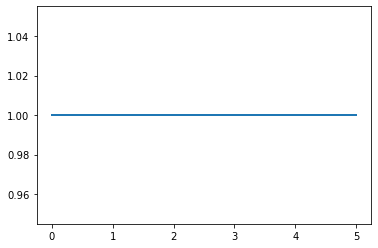

/tmp/ipykernel_813735/1372673632.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s, dtype=torch.float)


Time cost in computing gradients:  5.383899688720703
shit
Time cost in computing gradients:  5.16545557975769
Initial descent succeeds:  tensor(True)
Observation:  tensor(0.0125)
Gradient (scaled):  tensor([-2.6321,  2.6263, -0.0434, -0.3622])
Relative error of observation:  tensor(0.0033)
Time cost in computing gradients:  4.882074594497681
The 1th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.8234,  0.8204, -0.0159, -0.1855])
Relative error of observation:  tensor(0.0021)
Time cost in computing gradients:  4.789470434188843
The 2th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.4699,  0.4676, -0.0120, -0.1500])
Relative error of observation:  tensor(0.0020)
Time cost in computing gradients:  4.842219114303589
The 3th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.2408,  0.2389, -0.0095, -0.1269])
Relative error of observation:  tensor(0.0019)
Time cost in computing gradients:  4.701154708862305
The 4th descent succeeds:  tensor(True)
G

KeyboardInterrupt: 

In [117]:
## Number of total alpha-beta iterations
N_AllIters = 1
this_alpha = alpha0
this_beta = beta0

## Run alpha-beta iterations
for i in range(N_AllIters):
    # Print out info
    print("#" * 40, " Total Iteration {0} ".format(i) + "#" * 40)
    
    ## First optimize alpha
    kwgs['alpha0'] = this_alpha
    kwgs['beta_this'] = this_beta
    
    # Timing alpha
    # Update this Alpha
    # this_alpha = optAlpha(O_GAN, kwgs)
    
    
    ## Run grad descent on beta
    # Generate target v
    v, t = generate_target_v(this_alpha, kwgs['VT'], kwgs['beta_targ'], kwgs['y0'], kwgs['regularizedFlag'])
    
    # Run gradient descent
    myGradBB = GradDescent(this_alpha, kwgs['alp_low'], kwgs['alp_high'], kwgs['VT'], 
                           this_beta, kwgs['beta_low'], kwgs['beta_high'], 
                           kwgs['y0'], v, t, 
                           objGrad_func = objGradFunc, scaling = scaling, 
                           max_steps = 10, stepping = 'BB', obs_rtol = 1e-5, lsrh_steps = 10)
    
    myGradBB.run()
    
    # Update parameters
    this_beta = myGradBB.beta_optimal
    print("Optimal beta: ", this_beta)

# Optimize by $\alpha=[k, m, g]$ and $V$

In [31]:
# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-8
this_atol = 1.e-10

# Obtain observation at (alpha, beta_this, beta_targ, y0)
def O_GAN(alpha, beta_this, beta_targ, y0, regFlag):
    # Changing the y0 to match V with v 
    alp = torch.tensor(alpha, dtype = torch.float)
    y0[1] = alp[2]
    
    # DEBUG LINES
#     print('alpha: ', alpha)
#     print('beta_this: ', beta_this)
#     print('beta_targ: ', beta_targ)
#     print('y0: ', y0)
    
    # Get target sequence
    targ_SpringSlider = MassFricParams(alp, beta_targ, y0)
    
    # Run the sequence
    targ_seq = TimeSequenceGen(T, 
                               NofTPts, 
                               targ_SpringSlider, 
                               rtol=this_rtol, 
                               atol=this_atol, 
                               regularizedFlag=regFlag)
#     # DEBUG LINE: Print targ seq finished
#     print("Target sequence finished.")
    v = targ_seq.default_y[1, :]
    
    # Get this sequence
    this_SpringSlider = MassFricParams(alp, beta_this, y0)
    this_seq = TimeSequenceGen(T, 
                               NofTPts, 
                               this_SpringSlider, 
                               rtol=this_rtol, 
                               atol=this_atol, 
                               regularizedFlag=regFlag)
    
#     # DEBUG LINE
#     print("This sequence finished.")
    res = O(this_seq.default_y, v, this_seq.t, this_SpringSlider)
    
#     # DEBUG LINE
#     print('Objective value: ', res, '\n')
    
    return res

# Try to find maximum of O_GAN in terms of alpha
def optAlpha(Obs_func, kwargs):
    # Unzip the arguments
    beta_this = kwargs['beta_this']
    alpha0 = kwargs['alpha0']
    beta_targ = kwargs['beta_targ']
    y0 = kwargs['y0']
    
    # Other parameters for simulated annealing function
    alp_low = kwargs['alp_low']
    alp_hi = kwargs['alp_high']
    max_iters = kwargs['max_iters']
    regFlag = kwargs['regularizedFlag']
    maxFuncCalls = kwargs['maxFuncCalls']
    noLocalSearch = kwargs['noLocalSearch']
    
    # Define the function
    func = lambda x: -Obs_func(x, beta_this, beta_targ, y0, regFlag)
    
    # Use dual-simulated-annealing grad-free method to optimize for alpha
    new_alpha = opt.dual_annealing(func, 
                                   [(alp_low[i], alp_hi[i]) for i in range(len(alp_low))], 
                                   maxiter = max_iters, 
                                   x0 = alpha0, 
                                   maxfun = maxFuncCalls, 
                                   no_local_search = noLocalSearch
                                  ).x
    
    return torch.tensor(new_alpha, dtype = torch.float)

# Iterative alpha-beta example

In [44]:
# Set up the parameters
alpha0 = torch.tensor([50., 1., 1., 9.8])

# Alpha range
alp_low = torch.tensor([50., 0.5, 1., 9.])
alp_hi = torch.tensor([100., 2., 10., 10.])
y0 = torch.tensor([0., 1.0, 1.0])

# Start beta
beta0 = torch.tensor([0.004, 0.008, 2.e-3, 0.5])

# Target beta
beta_targ = torch.tensor([0.011, 0.016, 1.e-3, 0.58])

# Beta ranges
beta_low = torch.tensor([0.001, 0.006, 0.5e-3, 0.3])
beta_high = torch.tensor([0.021, 0.026, 5, 0.8])
scaling = torch.tensor([1., 1., 1., 1.])

# Other arguments for optAlpha function
max_iters = 10
maxFuncCalls = 200
regularizedFlag = False
noLocalSearch = True

# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-8
this_atol = 1.e-10

# Store the keywords for optAlpha
kwgs = {
    'y0' : y0, 
    'alpha0' : alpha0, 
    'alp_low' : alp_low, 
    'alp_high' : alp_hi, 
    'max_iters' : max_iters, 
    'beta_this' : beta0, 
    'beta_targ' : beta_targ, 
    'beta_low' : beta_low, 
    'beta_high' : beta_high, 
    'regularizedFlag' : regularizedFlag, 
    'maxFuncCalls' : maxFuncCalls, 
    'noLocalSearch' : noLocalSearch
}

# Function to get target v
def generate_target_v(alpha, beta, y0, regularizedFlag = False):
    y0[1] = alpha[2]
    targ_SpringSlider = MassFricParams(alpha, beta, y0)
    targ_SpringSlider.print
    targ_seq = TimeSequenceGen(T, NofTPts, targ_SpringSlider, 
                               rtol=this_rtol, atol=this_atol, regularizedFlag=regularizedFlag)
    v = targ_seq.default_y[1, :], 
    t = targ_seq.t
    return v[0], t

## Give an example:

In [45]:
## Number of total alpha-beta iterations
N_AllIters = 10
this_alpha = alpha0
this_beta = beta0

## Run alpha-beta iterations
for i in range(N_AllIters):
    # Print out info
    print("#" * 40, " Total Iteration {0} ".format(i) + "#" * 40)
    
    ## First optimize alpha
    kwgs['alpha0'] = this_alpha
    kwgs['beta_this'] = this_beta
    
    # Timing alpha
    # Update this Alpha
    this_alpha = optAlpha(O_GAN, kwgs)
    
    
    ## Run grad descent on beta
    # Generate target v
    v, t = generate_target_v(this_alpha, kwgs['beta_targ'], kwgs['y0'], kwgs['regularizedFlag'])
    
    # Run gradient descent
    myGradBB = GradDescent(this_alpha, kwgs['alp_low'], kwgs['alp_high'], 
                           this_beta, kwgs['beta_low'], kwgs['beta_high'], 
                           kwgs['y0'], v, t, 
                           objGrad_func = objGradFunc, scaling = scaling, 
                           max_steps = 10, stepping = 'BB', obs_rtol = 1e-5, lsrh_steps = 10)
    
    myGradBB.run()
    
    # Update parameters
    this_beta = myGradBB.beta_optimal
    print("Optimal beta: ", this_beta)

    

########################################  Total Iteration 0 ########################################
Time cost in computing gradients:  16.575052738189697
shit
Time cost in computing gradients:  18.049540758132935
Initial descent succeeds:  tensor(True)
Observation:  tensor(0.1276)
Gradient (scaled):  tensor([-3.0636e+01,  1.4942e+01,  1.0977e-03, -1.9771e+00])
Relative error of observation:  tensor(0.0011)
Time cost in computing gradients:  18.91701912879944
The 1th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-3.3784e+00,  1.6592e+00, -7.8775e-04, -2.2021e-01])
Relative error of observation:  tensor(0.0001)
Time cost in computing gradients:  17.838680744171143
The 2th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.7293,  0.3551, -0.0009, -0.0477])
Relative error of observation:  tensor(3.2540e-05)
Time cost in computing gradients:  16.804880380630493
The 3th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.1457,  0.0676, -0.0009, -0.0097])

Time cost in computing gradients:  3.225739002227783
The 8th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0058,  0.3936,  0.0051, -0.0531])
Relative error of observation:  tensor(0.0005)
Time cost in computing gradients:  3.2491214275360107
The 9th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0057,  0.3868,  0.0050, -0.0522])
Relative error of observation:  tensor(0.0005)
Time cost in computing gradients:  2.5442821979522705
The 10th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0057,  0.3803,  0.0049, -0.0514])
Relative error of observation:  tensor(0.0004)
The final predicted parameters:  tensor([0.0119, 0.0060, 0.0017, 0.5035])
Optimal beta:  tensor([0.0119, 0.0060, 0.0017, 0.5035])
########################################  Total Iteration 3 ########################################
Time cost in computing gradients:  2.5299739837646484
shit
Time cost in computing gradients:  2.5278897285461426
Initial descent succeeds:  tensor(True

Time cost in computing gradients:  2.8541035652160645
The 5th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0044,  0.2544,  0.0031, -0.0356])
Relative error of observation:  tensor(0.0003)
Time cost in computing gradients:  2.875577449798584
The 6th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0044,  0.2498,  0.0030, -0.0350])
Relative error of observation:  tensor(0.0003)
Time cost in computing gradients:  2.8880913257598877
The 7th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0042,  0.2452,  0.0029, -0.0344])
Relative error of observation:  tensor(0.0003)
Time cost in computing gradients:  2.9145069122314453
The 8th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0042,  0.2404,  0.0029, -0.0337])
Relative error of observation:  tensor(0.0003)
Time cost in computing gradients:  2.8783016204833984
The 9th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([ 0.0041,  0.2360,  0.0027, -0.0331])
Relative error of 

Time cost in computing gradients:  22.42765712738037
The 2th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-0.0046, -0.0048,  0.0017, -0.0003])
Relative error of observation:  tensor(2.1169e-05)
Time cost in computing gradients:  22.420302391052246
The 3th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([-0.0022, -0.0060,  0.0013, -0.0001])
Relative error of observation:  tensor(2.1233e-05)
Time cost in computing gradients:  22.816274404525757
The 4th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([-0.0034, -0.0054,  0.0015, -0.0002])
Relative error of observation:  tensor(2.1286e-05)
Time cost in computing gradients:  22.120280504226685
The 5th descent succeeds:  tensor(True)
Gradient (scaled):  tensor([-3.5104e-04, -6.8668e-03,  2.3667e-03,  9.6894e-06])
Relative error of observation:  tensor(2.1247e-05)
Time cost in computing gradients:  22.153485774993896
The 6th descent succeeds:  tensor(False)
Gradient (scaled):  tensor([-0.0029, -0.0057,  0

In [118]:
## Fixed parameters
# Parameters for the spring-slider
k = 100.
m = 1.
VT = torch.tensor([[1., 1.], [0., 5.]])
g = 9.8
y0 = torch.tensor([0., 1.0, 1.0])
kmg = torch.tensor([k, m, g])
# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-8
this_atol = 1.e-10

--------------------  Mass and spring parameters  --------------------
k:         tensor(100.)
m:         tensor(1.)
g:         tensor(9.8000)


--------------------  Rate-and-state parameters  --------------------
fr:        tensor(0.5800)
a:         tensor(0.0110)
b:         tensor(0.0160)
DRS:       tensor(0.0010)
y0:        tensor([0., 1., 1.])


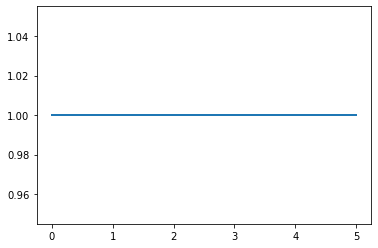

/tmp/ipykernel_813735/1372673632.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s, dtype=torch.float)


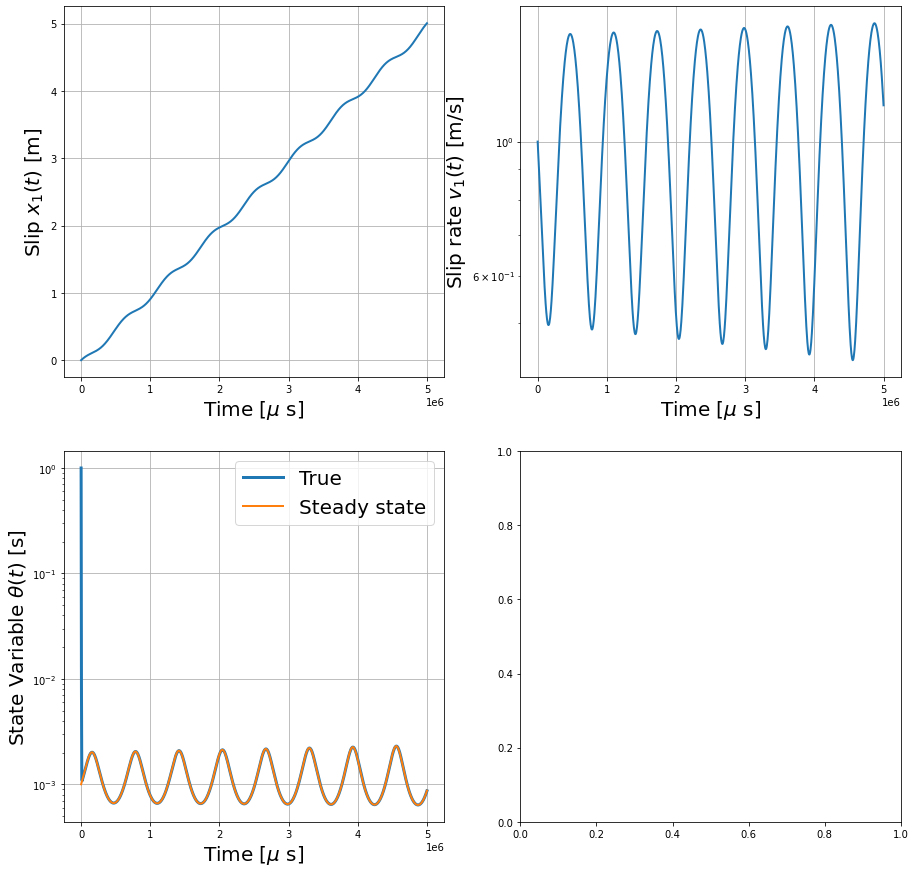

In [119]:
# Generate target v
targ_RSParams = torch.tensor([0.011, 0.016, 1.e-3, 0.58])
targ_SpringSlider = MassFricParams(kmg, VT, targ_RSParams, y0)
targ_SpringSlider.print_info()
targ_seq = TimeSequenceGen(T, NofTPts, targ_SpringSlider, rtol=this_rtol, atol=this_atol, regularizedFlag=False)
v = targ_seq.default_y[1, :]
targ_seq.plotY(targ_seq.t, targ_seq.default_y)

/tmp/ipykernel_813735/1372673632.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s, dtype=torch.float)


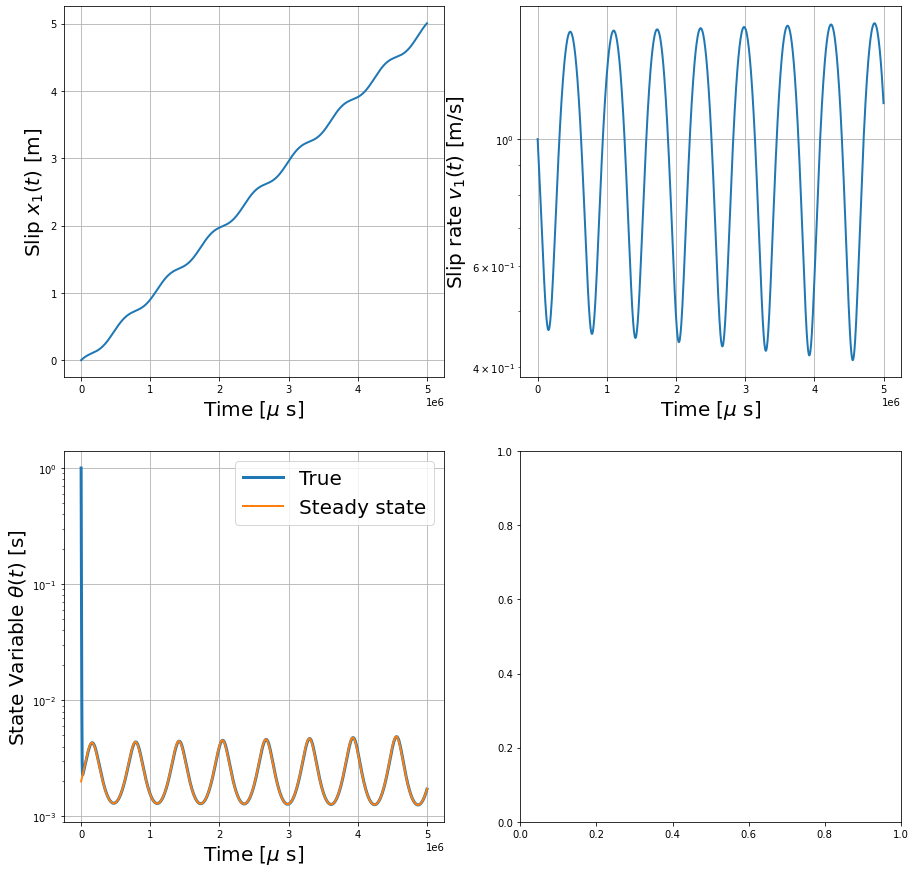

In [120]:
# A new set of RS params
new_RSParams = torch.tensor([0.004, 0.008, 2.e-3, 0.6])
# new_RSParams = torch.tensor([0.011, 0.016, 1.e-3, 0.58])
new_SpringSlider = MassFricParams(kmg, VT, new_RSParams, y0)
new_seq = TimeSequenceGen(T, NofTPts, new_SpringSlider, rtol=this_rtol, atol=this_atol, regularizedFlag=False)
new_seq.plotY(new_seq.t, new_seq.default_y)

In [121]:
# Report observation:
Obs = O(new_seq.default_y, v, new_seq.t, new_SpringSlider)
print('Observation vector: ', Obs)

Observation vector:  tensor(0.0020)


In [122]:
# Calculate DoDBeta
myADJ = AdjDerivs(new_seq.default_y, v, new_seq.t, new_SpringSlider, rtol = 1.e-6, atol = 1.e-8)


Time cost in computing gradients:  2.854267120361328


In [123]:
myADJ.dOdBeta

tensor([ 0.9916, -0.9909,  0.0115,  0.1470])

In [124]:
myADJ.T

tensor(5.)

In [128]:
# Get the finite-difference gradients
perturbRatio = 0.001
numericalGrad = torch.zeros(new_RSParams.shape)
Rtol = 1.e-8
Atol = 1.e-10

# Loop through all beta's components
for i in range(len(new_RSParams)):
    RSParamsPlus = torch.clone(new_RSParams)
    RSParamsPlus[i] = RSParamsPlus[i] * (1 + perturbRatio)
    RSParamsMinus = torch.clone(new_RSParams)
    RSParamsMinus[i] = RSParamsMinus[i] * (1 - perturbRatio)
    
    print("-" * 40)
    print("RSParams: ", new_RSParams)
    print("RSParamsPlus: ", RSParamsPlus)
    print("RSParamsMinus: ", RSParamsMinus)
    
    # kmg, VT, targ_RSParams, y0
    # Calculate two observations
    SpringSliderPlus = MassFricParams(kmg, VT, RSParamsPlus, y0)
    seqPlus = TimeSequenceGen(T, NofTPts, SpringSliderPlus, Rtol, Atol, regularizedFlag=False)
    OPlus = O(seqPlus.default_y, v, seqPlus.t, SpringSliderPlus)
    
    SpringSliderMinus = MassFricParams(kmg, VT, RSParamsMinus, y0)
    seqMinus = TimeSequenceGen(T, NofTPts, SpringSliderMinus, Rtol, Atol, regularizedFlag=False)
    OMinus = O(seqMinus.default_y, v, seqMinus.t, SpringSliderMinus)
    
    numericalGrad[i] = (OPlus - OMinus) / (RSParamsPlus[i] - RSParamsMinus[i])

print('Numerical gradient: ', numericalGrad)

----------------------------------------
RSParams:  tensor([0.0040, 0.0080, 0.0020, 0.6000])
RSParamsPlus:  tensor([0.0040, 0.0080, 0.0020, 0.6000])
RSParamsMinus:  tensor([0.0040, 0.0080, 0.0020, 0.6000])


/tmp/ipykernel_813735/1372673632.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s, dtype=torch.float)


----------------------------------------
RSParams:  tensor([0.0040, 0.0080, 0.0020, 0.6000])
RSParamsPlus:  tensor([0.0040, 0.0080, 0.0020, 0.6000])
RSParamsMinus:  tensor([0.0040, 0.0080, 0.0020, 0.6000])
----------------------------------------
RSParams:  tensor([0.0040, 0.0080, 0.0020, 0.6000])
RSParamsPlus:  tensor([0.0040, 0.0080, 0.0020, 0.6000])
RSParamsMinus:  tensor([0.0040, 0.0080, 0.0020, 0.6000])
----------------------------------------
RSParams:  tensor([0.0040, 0.0080, 0.0020, 0.6000])
RSParamsPlus:  tensor([0.0040, 0.0080, 0.0020, 0.6006])
RSParamsMinus:  tensor([0.0040, 0.0080, 0.0020, 0.5994])
Numerical gradient:  tensor([ 1.1060, -1.0251,  0.2233,  0.1493])
